In [1]:
from itertools import product, combinations
from collections import Counter
import math
import base64
import io
import json
from pathlib import Path
from collections import Counter
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import torch
import Levenshtein
from tensorboard.backend.event_processing import event_accumulator
from plotnine import *
import numpy as np
import random
import magicsoup as ms
from e1_co2_fixing.chemistry import CHEMISTRY, ESSENTIAL_MOLS

theme_set(theme_minimal())
THIS_DIR = Path(".") / "e1_co2_fixing"
RUN_NAME = "2023-05-02_11-56_0"
RUN_DIR_ROOT = THIS_DIR / "runs"
RUN_DIR = RUN_DIR_ROOT / RUN_NAME

# Run 2023-04-27_14-40


In [2]:
with open(RUN_DIR / "hparams.json") as fh:
    hparams = json.load(fh)
hparams

{'n_init_gens': 100.0,
 'n_adapt_gens': 500.0,
 'mut_scheme': 'linear',
 'split_ratio': 0.2,
 'split_thresh_cells': 0.7,
 'split_thresh_mols': 0.2,
 'genome_init': 'transporter'}

In [3]:
scalars = [
    ("Cells/total", "cells"),
    ("Cells/Generation", "generation"),
    ("Cells/Survival", "survival"),
    ("Molecules/CO2[ext]", "CO2[e]"),
    ("Molecules/CO2[int]", "CO2[i]"),
    ("Molecules/E[ext]", "E[e]"),
    ("Molecules/E[int]", "E[i]"),
    ("Molecules/X[ext]", "X[e]"),
    ("Molecules/X[int]", "X[i]"),
    ("Other/Split", "split")
]

records = []
for tf_event_file in RUN_DIR.glob("*.out.tfevents.*"):
    tf_ea = event_accumulator.EventAccumulator(str(tf_event_file))
    tf_ea.Reload()
    for tag, label in scalars:
        for obj in tf_ea.Scalars(tag):
            records.append({
                "scalar": label,
                "value": obj.value,
                "step": obj.step,
            })
scalars_df = pd.DataFrame.from_records(records)

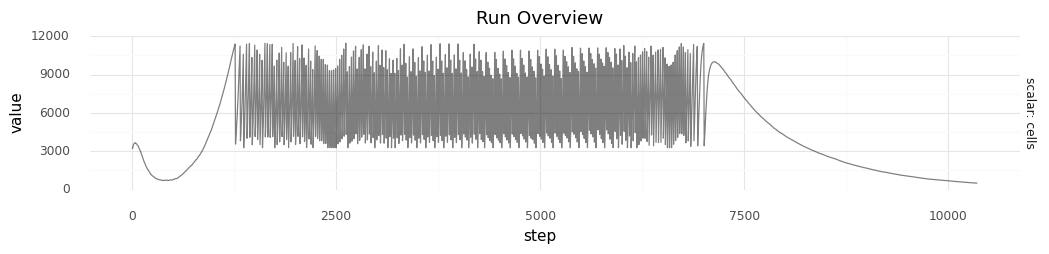

<ggplot: (8772575553074)>

In [4]:
(ggplot(scalars_df[scalars_df["scalar"] == "cells"])
    + geom_line(aes(y="value", x="step"), alpha=0.5)
    + facet_grid("scalar ~ .", scales="free", labeller="label_both")
    + theme(figure_size=(12, 2))
    + ggtitle("Run Overview"))

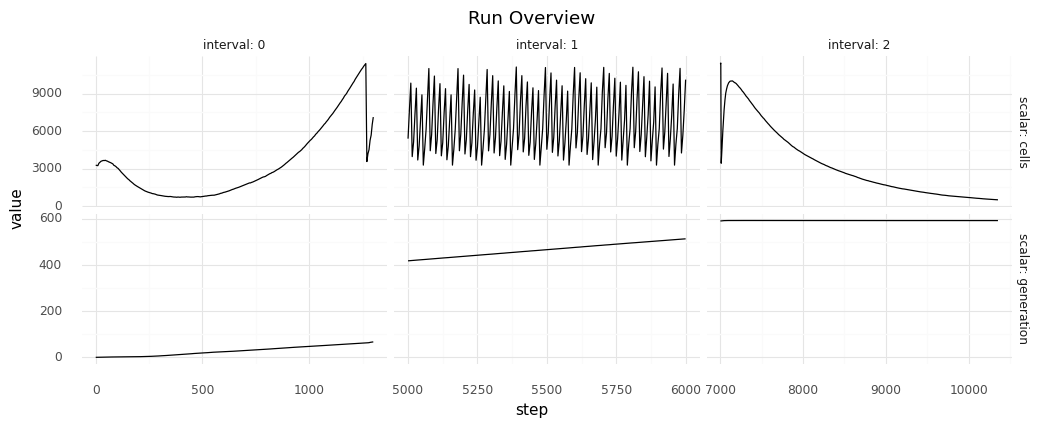

<ggplot: (8772572595396)>

In [5]:
vars = ["cells", "generation"]
intervals = [
    (0, 1_300),
    (5_000, 6_000),
    (7_000, 11_000),
]

scalars_df["interval"] = -1
for i, (a, b) in enumerate(intervals):
    scalars_df.loc[(scalars_df["step"] >= a) & (scalars_df["step"] <= b), "interval"] = i

(ggplot(scalars_df[scalars_df["scalar"].isin(vars) & (scalars_df["interval"] >= 0)])
    + geom_line(aes(y="value", x="step"))
    + facet_grid("scalar ~ interval", scales="free", labeller="label_both")
    + theme(figure_size=(12, 4))
    + ggtitle("Run Overview"))

In [6]:
# extract splits
df = scalars_df.loc[scalars_df["scalar"] == "split"]
splits_df = df.loc[df["value"].diff(periods=1) > 0.0, ["step"]]
scalars_df = scalars_df[scalars_df["scalar"] != "split"]

# map generations
gens = scalars_df.loc[scalars_df["scalar"] == "generation", ["value", "step"]]
gens = gens.rename(columns={"value": "generation"})
scalars_df = scalars_df.merge(gens, on="step")
scalars_df = scalars_df[scalars_df["scalar"] != "generation"]

# label molecules
scalars_df["label"] = [d.split("[")[0] for d in scalars_df["scalar"]]
scalars_df["label"] = pd.Categorical(scalars_df["label"], categories=["cells", "CO2", "E", "X"])
scalars_df["localization"] = ""
scalars_df.loc[[d.endswith("[i]") for d in scalars_df["scalar"]], "localization"] = "int"
scalars_df.loc[[d.endswith("[e]") for d in scalars_df["scalar"]], "localization"] = "ext"

In [12]:
def plot_molecules(df: pd.DataFrame, interval: int, title: str, size=(10, 4)):
    vars = ["cells", "CO2[i]", "CO2[e]", "E[i]", "E[e]", "X[i]", "X[e]"]
    df = df[df["scalar"].isin(vars)].copy()

    int_mask = df["interval"] == interval
    cell_mask = df["scalar"] == "cells"
    nocell_mask = df["scalar"] != "cells"

    return (ggplot(df)
        + geom_line(aes(y="value", x="step", color="localization"), df[int_mask & nocell_mask])
        + geom_line(aes(y="value", x="step"), data=df[int_mask & cell_mask])
        + facet_grid("label ~ .", scales="free_y", labeller="label_both")
        + theme(figure_size=size)
        + ggtitle(title))

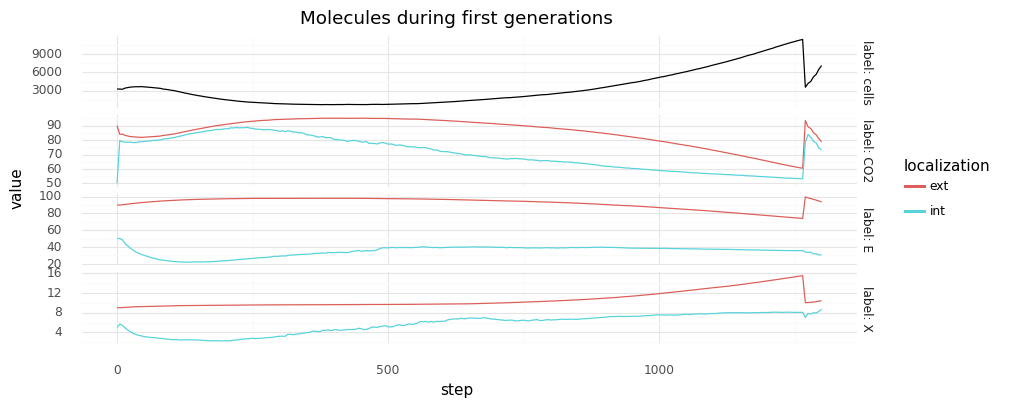

<ggplot: (8772571742800)>

In [13]:
plot_molecules(df=scalars_df, interval=0, title="Molecules during first generations")

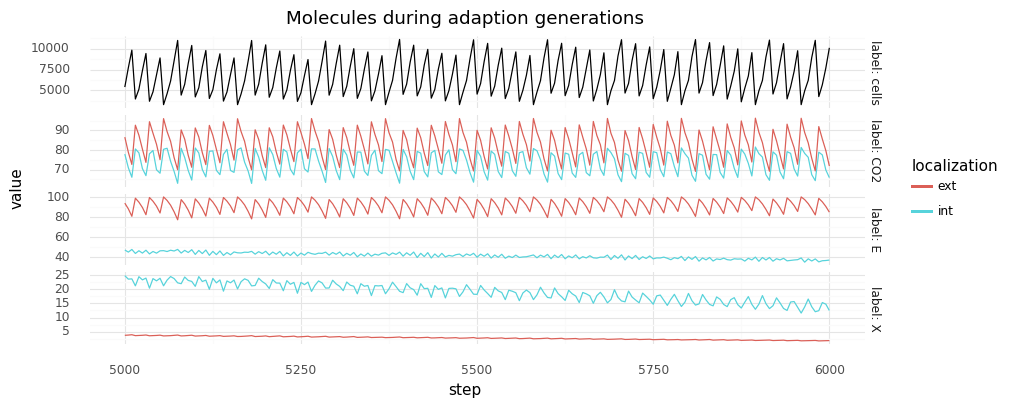

<ggplot: (8772571584467)>

In [14]:
plot_molecules(df=scalars_df, interval=1, title="Molecules during adaption generations")

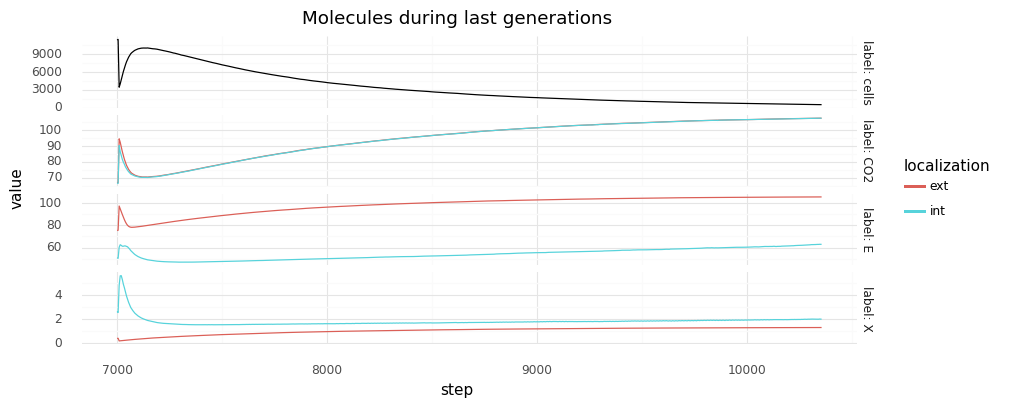

<ggplot: (8772566062978)>

In [15]:
plot_molecules(df=scalars_df, interval=2, title="Molecules during last generations")

In [16]:
def load_img_maps(from_step: int, to_step: int, size=1000) -> dict:
    out = {}
    for tf_event_file in RUN_DIR.glob("*.out.tfevents.*"):
        tf_ea = event_accumulator.EventAccumulator(str(tf_event_file), {"images": size})
        tf_ea.Reload()
        for obj in tf_ea.Images("Maps/Cells"):
            if from_step <= obj.step <= to_step:
                out[obj.step] = obj.encoded_image_string
    return out

In [17]:
def plot_cell_maps(img_maps: dict, title="Cell maps", n_cols=11, w=15, h=1.8):
    steps = sorted(list(img_maps))
    n_rows = math.ceil(len(steps) / n_cols)
    fig, axs = plt.subplots(n_rows, n_cols, sharex=True, sharey=True, figsize=(w, h * n_rows))
    for step, ax in zip(steps, axs.flatten()):
        bimg = io.BytesIO(img_maps[step])
        img = mpimg.imread(bimg, format='JPG')
        ax.imshow(img, interpolation='nearest')
        ax.title.set_text(f"step {step}")
    fig.suptitle(title)
    plt.show()

In [ ]:
maps0 = load_img_maps(0, 1_300)
maps1 = load_img_maps(7_000, 11_000)

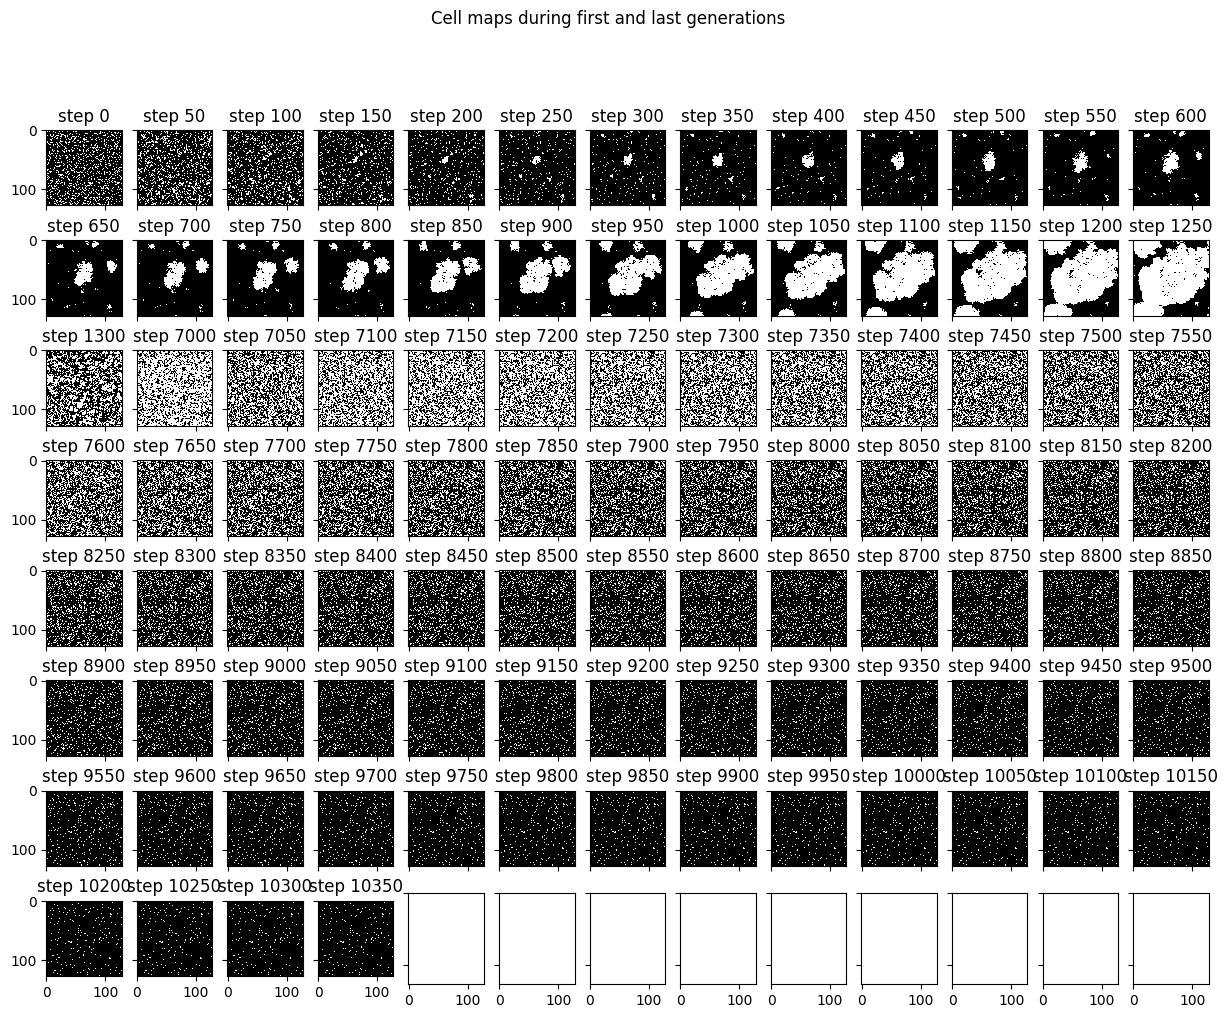

In [23]:
plot_cell_maps({**maps0, **maps1}, title="Cell maps during first and last generations", n_cols=13, w=15, h=1.4)

asd

In [24]:
world = ms.World.from_file(rundir=RUN_DIR_ROOT, device="cpu")

In [25]:
steps_map = {}
for statedir in RUN_DIR.glob("step=*"):
    step = int(statedir.name.split("step=")[-1])
    world.labels = []
    world.genomes = []
    world.load_state(statedir=statedir, ignore_cell_params=True)
    labs = [d for d in world.labels]
    steps_map[step] = {
        "ls": world.labels.copy(),
        "gs": world.genomes.copy(),
    }

In [38]:
sampling_ratio = 0.1

def entropy(counts: list) -> float:
    a = np.array([d for d in counts if d > 0])
    return np.sum(a * np.log(a))

records = []
for step, obj in steps_map.items():
    ulabs = set(obj["ls"])
    lcounts = Counter(obj["ls"])
    ugenomes = list(set(obj["gs"])) 
    samples = random.sample(ugenomes, k=int(len(ugenomes) * sampling_ratio))
    dists = [Levenshtein.distance(a, b) for a, b in combinations(samples, 2)]
    records.append({
        "step": step,
        "len_genome": np.mean([len(d) for d in obj["gs"]]),
        "ent_origin": entropy(lcounts.values()),
        "n_origin": len(ulabs),
        "dist": np.mean(dists)
    })

cells_df = pd.DataFrame.from_records(records)

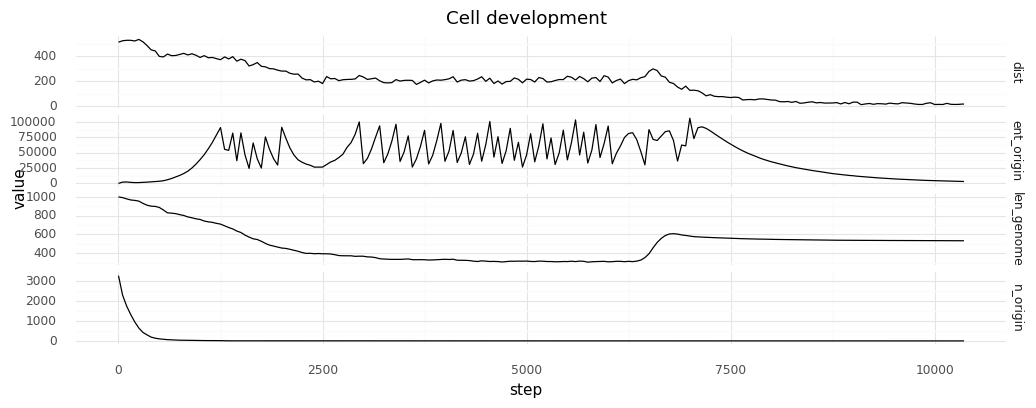

<ggplot: (8772565049059)>

In [59]:
df = cells_df.melt(id_vars=["step"], var_name="var")

(ggplot(df)
    + geom_line(aes(y="value", x="step"))
    + facet_grid("var ~ .", scales="free")
    + theme(figure_size=(12, 4))
    + ggtitle("Cell development"))

In [44]:
last_step = sorted(steps_map.keys(), reverse=True)[0]
world.load_state(RUN_DIR / f"step={last_step}")
world.load_state(RUN_DIR / f"step={7000}")

In [58]:
for prot in world.get_cell(by_idx=1).proteome:
    doms = [d for d in prot.domains if isinstance(d, ms.CatalyticDomain)]
    if len(doms) > 0:
        strs = [" + ".join(dd.name for dd in d.substrates) + " <-> " + " + ".join(dd.name for dd in d.products) for d in doms]
        print(", ".join(strs))

HS-CoA + acetoacetyl-CoA <-> acetyl-CoA + acetyl-CoA
HS-CoA + acetoacetyl-CoA <-> acetyl-CoA + acetyl-CoA
HS-CoA + acetoacetyl-CoA <-> acetyl-CoA + acetyl-CoA
HS-CoA + X + X + X + X + X <-> acetyl-CoA
HS-CoA + X + X + X + X + X <-> acetyl-CoA
